In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch

from analysis_utils import get_sparsity_info, merge_info_dicts, get_viz_data

In [3]:
output_folder = "charts"
model_type = "bertbase" # bertl4

#### Modular Model

In [4]:
folder = f"/share/home/lukash/pan16/{model_type}/cp_modular"
if "bertl4" in folder:
    experiment_name = "modular-diff_pruning_0.05-bert_uncased_L-4_H-256_A-4-64-2e-05-weighted_loss_prot-gender_age-seed{}.pt"
else:
    experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"
# os.listdir(folder)

In [5]:
modular_model_dicts, modular_model_layer_dicts, modular_model_module_dicts = get_sparsity_info(folder, experiment_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.we

In [6]:
modular_dict, modular_layer_dict, modular_module_dict, modular_emb_dict, modular_layer_list = get_viz_data(modular_model_dicts, modular_model_layer_dicts, modular_model_module_dicts)

#### Baseline

In [7]:
folder = f"/share/home/lukash/pan16/{model_type}/cp"
if "bertl4" in folder:
    experiment_name_adv = "adverserial-diff_pruning_0.05-bert_uncased_L-4_H-256_A-4-64-2e-05-weighted_loss_prot-age-seed{}.pt"
    experiment_name_task = "task-diff_pruning_0.05-bert_uncased_L-4_H-256_A-4-64-2e-05-seed{}.pt"
else:
    experiment_name_adv = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-age-seed{}.pt"
    experiment_name_task = "task-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-seed{}.pt"

In [8]:
adv_model_dicts, adv_model_layer_dicts, adv_model_module_dicts = get_sparsity_info(folder, experiment_name_adv)
task_model_dicts, task_model_layer_dicts, task_model_module_dicts = get_sparsity_info(folder, experiment_name_task)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.we

In [9]:
res = []
for d_list in [[task_model_dicts, adv_model_dicts], [task_model_layer_dicts, adv_model_layer_dicts], [task_model_module_dicts, adv_model_module_dicts]]:
    res.append(merge_info_dicts(*d_list))
base_model_dicts, base_layer_dicts, base_module_dicts = res
base_dict, base_layer_dict, base_module_dict, base_emb_dict, base_layer_list = get_viz_data(base_model_dicts, base_layer_dicts, base_module_dicts)

### Viz

In [28]:
n_layers = len(base_layer_list)
n_layers_adj = n_layers * 2
n_modules = len(base_layer_list[0])
module_names = list(base_layer_list[0].keys())

colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
color_fn = lambda x: abs(x-1)-0.2

width = 1
spacing = width / 4
y_coords = np.arange(n_layers_adj)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width + spacing*2, y_coords[-1] + width*2 + spacing*2]]
)
y_tick_coords = np.arange(n_layers_adj, step=2) + .5

hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-2] - width/2],
    y_coords_adj[-2:] + width/2
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

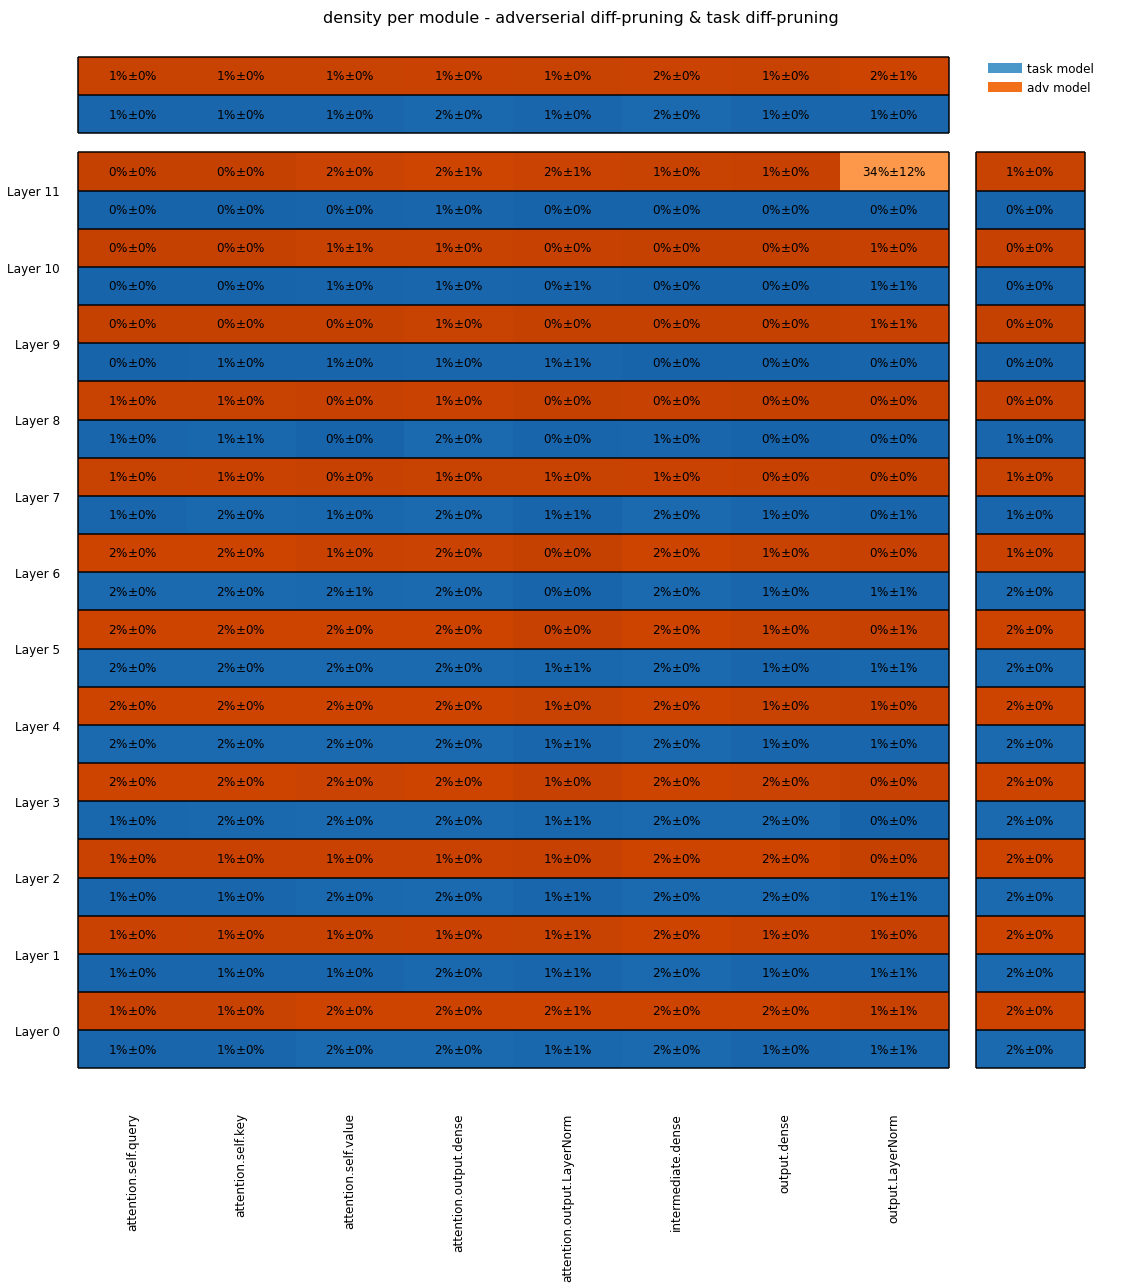

In [29]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(16, 18))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = [np.stack(x) for x in zip(*[l[m_name] for l in base_layer_list])]
    m_averages, m_error_margins = base_module_dict[m_name]
    color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]

    color.append("w")
    color.extend([c(color_fn(a)) for c,a in zip(colors, m_averages)])

    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
        plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    for y, a, e in zip(y_coords_adj[-2:], m_averages, m_error_margins):
        plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = [np.stack(x) for x in zip(*list(base_layer_dict.values())[1:])]
color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
    plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-3]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-2]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_tick_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)

plt.title("density per module - adverserial diff-pruning & task diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-10)
plt.tick_params(axis="y", left=False, pad=-40)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task model", "adv model"], bbox_to_anchor=(.97, .96), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_per_module_baselines.png"))
plt.show()

In [30]:
n_layers = len(modular_layer_list)
n_layers_adj = n_layers * 2
n_modules = len(modular_layer_list[0])
module_names = list(modular_layer_list[0].keys())

colors = [plt.get_cmap('Blues'), plt.get_cmap('Oranges')]
color_fn = lambda x: abs(x-1)-0.2

width = 1
spacing = width / 4
y_coords = np.arange(n_layers_adj)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width + spacing*2, y_coords[-1] + width*2 + spacing*2]]
)
y_tick_coords = np.arange(n_layers_adj, step=2) + .5

hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-2] - width/2],
    y_coords_adj[-2:] + width/2
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

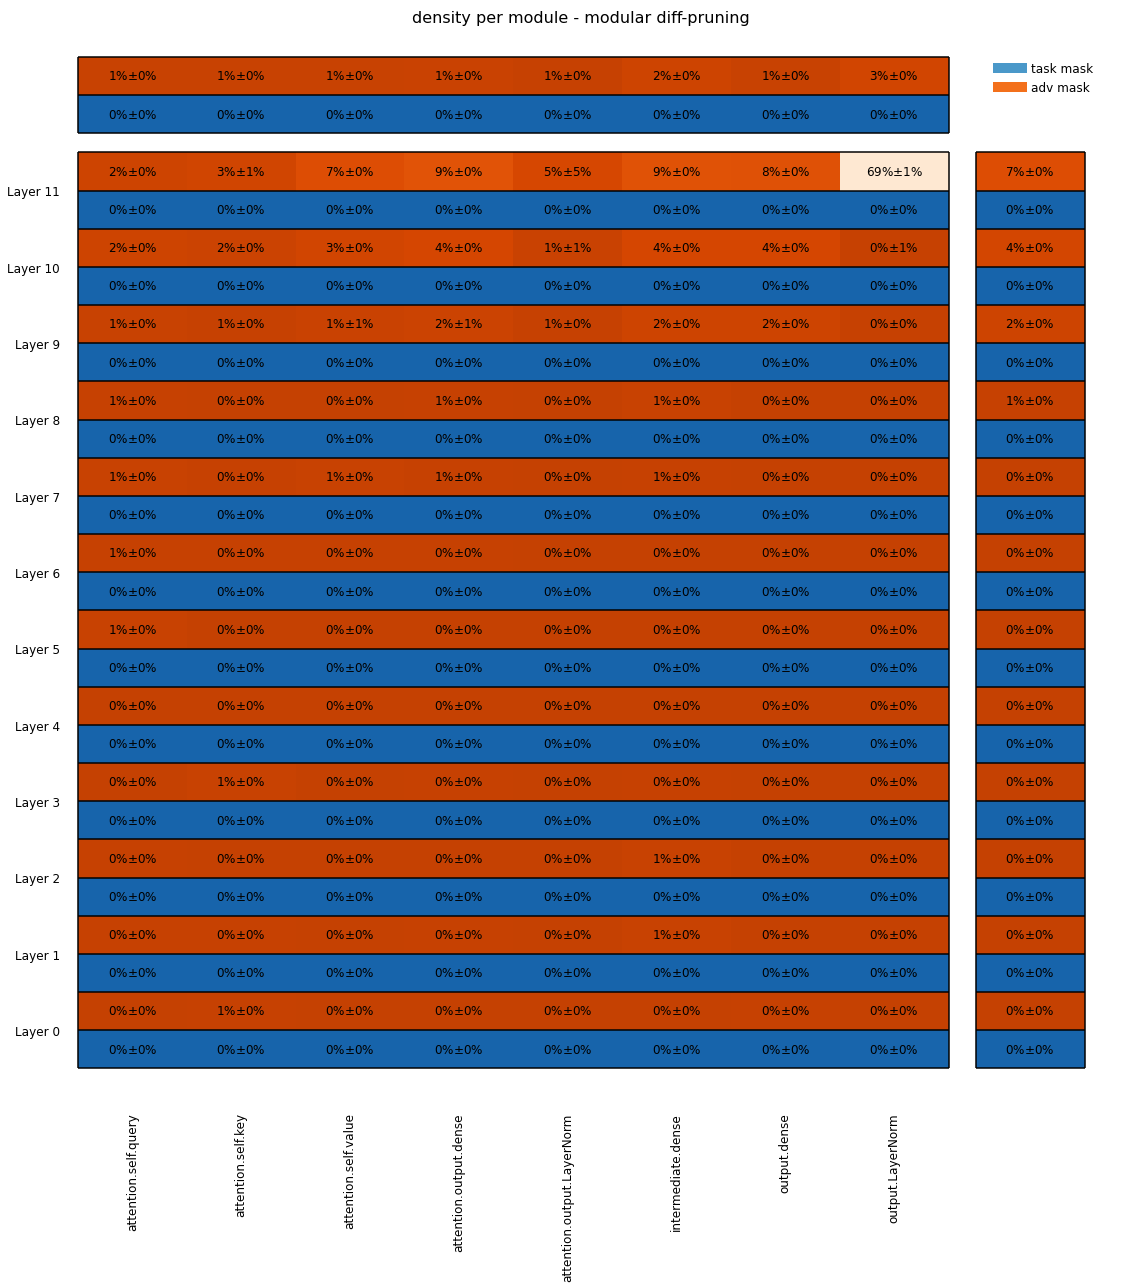

In [31]:
title_fontsize = 16
text_fontsize = 12

plt.figure(figsize=(16, 18)) # 20, 10
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    averages, error_margins = [np.stack(x) for x in zip(*[l[m_name] for l in modular_layer_list])]
    m_averages, m_error_margins = modular_module_dict[m_name]
    color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]

    color.append("w")
    color.extend([c(color_fn(a)) for c,a in zip(colors, m_averages)])

    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
        plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    for y, a, e in zip(y_coords_adj[-2:], m_averages, m_error_margins):
        plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

averages, error_margins = [np.stack(x) for x in zip(*list(modular_layer_dict.values())[1:])]
color = [c(color_fn(a)) for avgs in averages for c, a in zip(colors, avgs)]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, averages.flatten(), error_margins.flatten()):
    plt.text(start+width/2, y, "{:.0%}$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-3]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-2]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_tick_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)

plt.title("density per module - modular diff-pruning", fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-10)
plt.tick_params(axis="y", left=False, pad=-40)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task mask", "adv mask"], bbox_to_anchor=(.97, .96), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_per_module_modular.png"))
plt.show()

In [32]:
n_modules = len(base_emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]

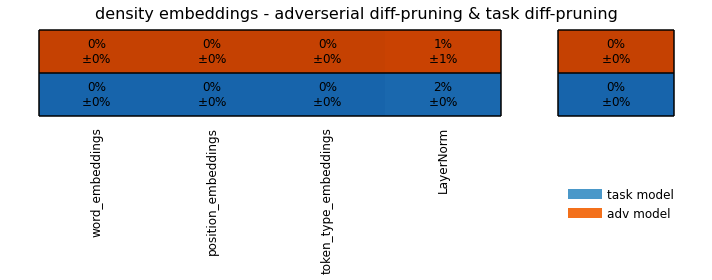

In [33]:
averages, error_margins= [np.stack(x, axis=1) for x in zip(*base_emb_dict.values())]
l_averages, l_error_margins = base_layer_dict[0]

plt.figure(figsize=(10,4))
for i, (avgs, errors, l_average, l_error) in enumerate(zip(averages, error_margins, l_averages, l_error_margins)):
    color = [colors[i](color_fn(a)) for a in avgs] + ["w", colors[i](color_fn(l_average))]
    plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], bottom=i*width, color=color)
    for x, a, e in zip(x_coords, avgs, errors):
        plt.text(x, width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(x_coords_adj[-1], width/2 + i, "{:.0%}\n$\pm${:.0%}".format(l_average, l_error), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in [0, width, width*2]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width*2, colors="black")

plt.bar(0, height=-width/2, width=width, color="w")

plt.xticks(x_coords, labels=base_emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - adverserial diff-pruning & task diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-20)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task model", "adv model"], bbox_to_anchor=(.97, -0.3), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_embedding_baselines.png"))
plt.show()

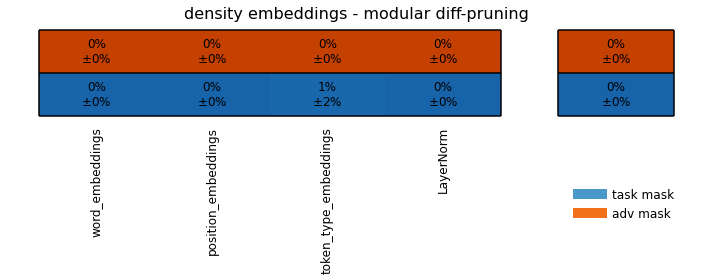

In [34]:
averages, error_margins= [np.stack(x, axis=1) for x in zip(*modular_emb_dict.values())]
l_averages, l_error_margins = modular_layer_dict[0]

plt.figure(figsize=(10,4))
for i, (avgs, errors, l_average, l_error) in enumerate(zip(averages, error_margins, l_averages, l_error_margins)):
    color = [colors[i](color_fn(a)) for a in avgs] + ["w", colors[i](color_fn(l_average))]
    plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], bottom=i*width, color=color)
    for x, a, e in zip(x_coords, avgs, errors):
        plt.text(x, width/2 + i, "{:.0%}\n$\pm${:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(x_coords_adj[-1], width/2 + i, "{:.0%}\n$\pm${:.0%}".format(l_average, l_error), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in [0, width, width*2]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width*2, colors="black")

plt.bar(0, height=-width/2, width=width, color="w")

plt.xticks(x_coords, labels=modular_emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title("density embeddings - modular diff-pruning", fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-20)

custom_lines = [Line2D([0], [0], color=c(0.6), lw=10) for c in colors]
plt.legend(custom_lines, ["task mask", "adv mask"], bbox_to_anchor=(.97, -0.3), frameon=False, fontsize=text_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "density_embedding_modular.png"))
plt.show()